In [3]:
import numpy as np # linear algebra
import pandas as pd #

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

In [4]:
from datetime import datetime, timedelta

# Load the data
df = pd.read_csv('historical_weather.csv')

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 182338 entries, 0 to 182337
Data columns (total 9 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   city_id             182338 non-null  object 
 1   date                182338 non-null  object 
 2   avg_temp_c          182313 non-null  float64
 3   min_temp_c          176452 non-null  float64
 4   max_temp_c          174845 non-null  float64
 5   precipitation_mm    112594 non-null  float64
 6   snow_depth_mm       12238 non-null   float64
 7   avg_wind_dir_deg    146944 non-null  float64
 8   avg_wind_speed_kmh  159866 non-null  float64
dtypes: float64(7), object(2)
memory usage: 12.5+ MB


In [5]:
def fill_avg_temp(row):
    if pd.isna(row['avg_temp_c']) and not pd.isna(row['min_temp_c']) and not pd.isna(row['max_temp_c']):
        return (row['min_temp_c'] + row['max_temp_c']) / 2
    return row['avg_temp_c']

In [6]:
df['avg_temp_c'] = df.apply(fill_avg_temp, axis=1)

In [5]:
def fill_min_temp(row):
    if pd.isna(row['min_temp_c']) and not pd.isna(row['avg_temp_c']) and not pd.isna(row['max_temp_c']):
        return 2 * row['avg_temp_c'] - row['max_temp_c']
    return row['min_temp_c']

def fill_max_temp(row):
    if pd.isna(row['max_temp_c']) and not pd.isna(row['avg_temp_c']) and not pd.isna(row['min_temp_c']):
        return 2 * row['avg_temp_c'] - row['min_temp_c']
    return row['max_temp_c']

df['min_temp_c'] = df.apply(fill_min_temp, axis=1)
df['max_temp_c'] = df.apply(fill_max_temp, axis=1)

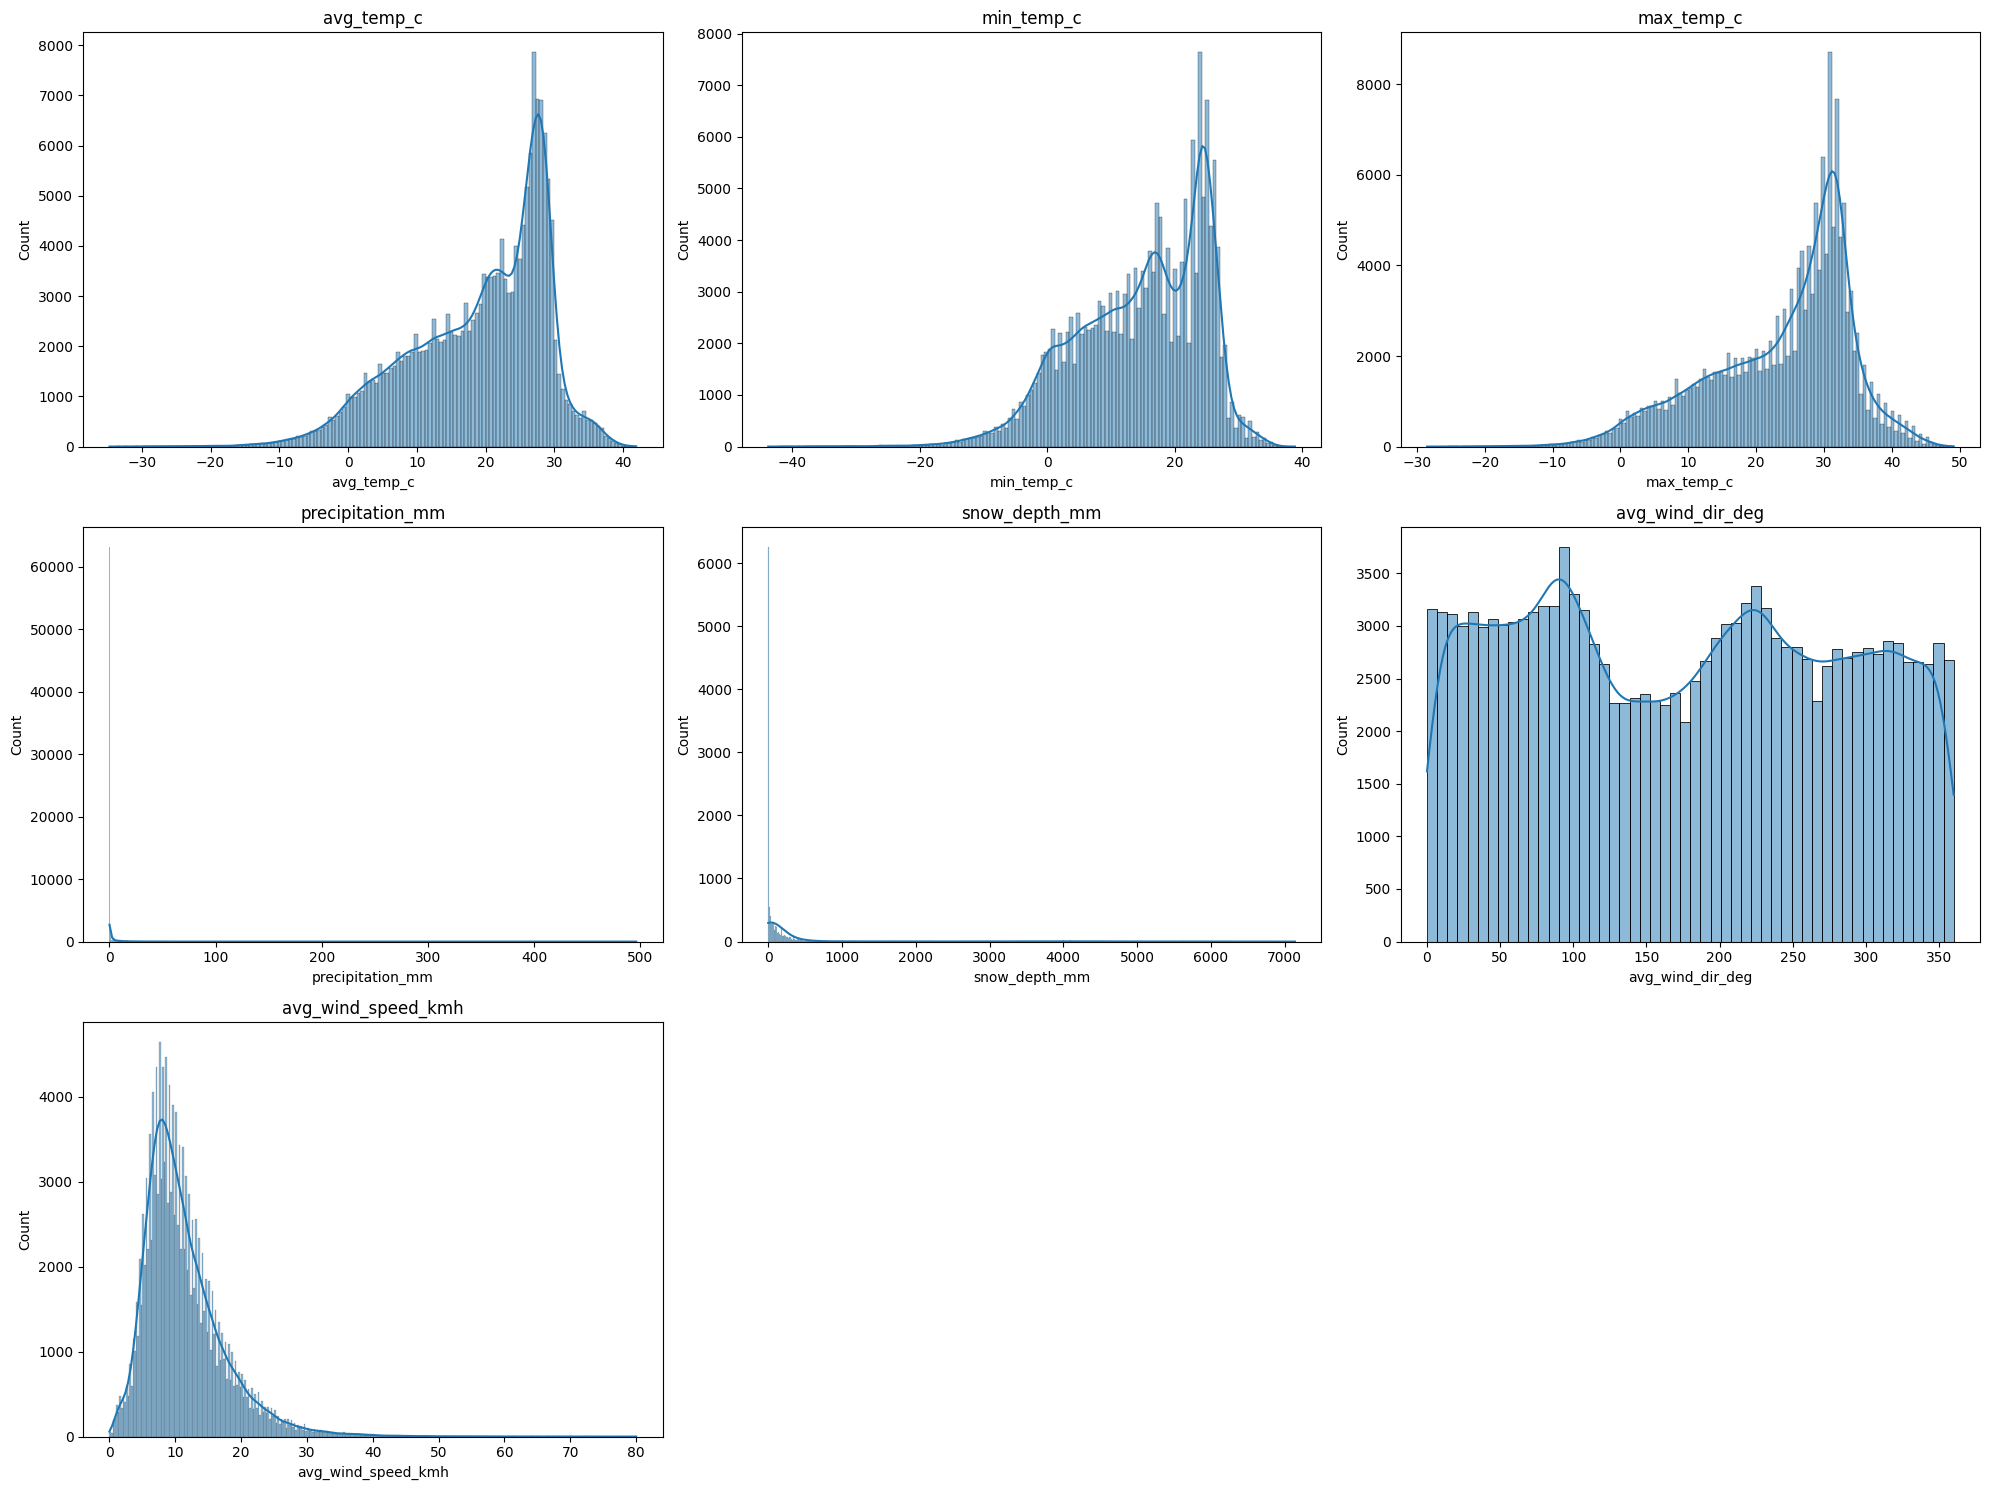

In [10]:
import seaborn as sns
import matplotlib.pyplot as plt

numeric_columns = df.select_dtypes(include=['float64', 'int64']).columns

plt.figure(figsize=(20, 15)) 
for i, column in enumerate(numeric_columns, 1):
    plt.subplot(len(numeric_columns) // 3 + 1, 3, i)  
    sns.histplot(df[column], kde=True)
    plt.title(column)

plt.tight_layout()
plt.show()

In [6]:
df = df[['city_id', 'date', 'avg_temp_c', 'min_temp_c', 'max_temp_c']]

In [7]:
import time
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split

def impute_temperatures(df):
    start_time = time.time()
    temp_cols = ['avg_temp_c', 'min_temp_c', 'max_temp_c']
    
    # First, use relationships between temperature columns
    for col in temp_cols:
        mask = df[col].isna()
        if mask.any():
            other_temps = [t for t in temp_cols if t != col]
            df.loc[mask, col] = df.loc[mask, other_temps].mean(axis=1)
    
    # For remaining NaNs, use SimpleImputer with median strategy
    imputer = SimpleImputer(strategy='median')
    df[temp_cols] = imputer.fit_transform(df[temp_cols])
    
    # Ensure min_temp <= avg_temp <= max_temp
    df['min_temp_c'] = np.minimum(df['min_temp_c'], df['avg_temp_c'])
    df['max_temp_c'] = np.maximum(df['max_temp_c'], df['avg_temp_c'])
    
    print(f"Temperature imputation completed in {time.time() - start_time:.2f} seconds")
    return df

In [8]:
df = impute_temperatures(df)

Temperature imputation completed in 0.14 seconds


In [27]:
def preprocess_temporal_data(df):
    df['date'] = pd.to_datetime(df['date'])
    df['year'] = df['date'].dt.year
    df['month'] = df['date'].dt.month
    df['day'] = df['date'].dt.day
    df['dayofyear'] = df['date'].dt.dayofyear
    return df
df = preprocess_temporal_data(df)


# Sort the dataframe by city_id and date
df = df.sort_values(['city_id', 'date'])


def calculate_rolling_averages(df):
    # Sort the dataframe by city_id and date
    df = df.sort_values(['city_id', 'date'])
    
    df['shifted_temp'] = df.groupby(['city_id'])['avg_temp_c'].shift(7)
    df['prev_year_temp'] = df.groupby(['city_id'])['avg_temp_c'].shift(365)
    df['shifted_max_temp'] = df.groupby(['city_id'])['max_temp_c'].shift(7)
    df['shifted_min_temp'] = df.groupby(['city_id'])['min_temp_c'].shift(7)
    
    return df

df = calculate_rolling_averages(df)

# Drop rows with NaN values
df = df.dropna()

print(df.head())
print(df.columns)

# Save the processed data
df.to_csv('processed_january_window_data.csv', index=False)

    city_id       date  avg_temp_c  min_temp_c  max_temp_c  year  month  day  \
730    C001 2016-01-01         4.9        -3.6        15.6  2016      1    1   
731    C001 2016-01-02         2.7        -5.5        14.4  2016      1    2   
732    C001 2016-01-03         3.2        -4.7        14.9  2016      1    3   
733    C001 2016-01-04         5.2        -2.9        15.1  2016      1    4   
734    C001 2016-01-05         6.6         1.5        13.2  2016      1    5   

     dayofyear  shifted_temp  prev_year_temp  city_encoded  shifted_max_temp  \
730          1           7.0             6.1             0              14.2   
731          2           6.3             3.2             0              14.4   
732          3           4.3             5.4             0              12.3   
733          4           4.1             2.5             0              10.4   
734          5           5.3             0.9             0               9.1   

     shifted_min_temp  
730           

In [59]:
from catboost import CatBoostRegressor

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = CatBoostRegressor(iterations=1000, learning_rate=0.1, depth=12, random_state=42)
model.fit(X_train, y_train, eval_set=(X_test, y_test), early_stopping_rounds=20, verbose=100)

# Make predictions
y_pred = model.predict(X_test)

# Evaluate the model
mse = np.sqrt(mean_squared_error(y_test, y_pred))
rmse = np.sqrt(mse)
print(f"RMSE: {rmse}")

0:	learn: 9.0358037	test: 9.0313319	best: 9.0313319 (0)	total: 53.9ms	remaining: 53.9s
100:	learn: 2.7398169	test: 2.8092565	best: 2.8092565 (100)	total: 5.43s	remaining: 48.4s
200:	learn: 2.5590637	test: 2.7114977	best: 2.7114977 (200)	total: 10.7s	remaining: 42.4s
300:	learn: 2.4306006	test: 2.6557818	best: 2.6557818 (300)	total: 15.9s	remaining: 37s
400:	learn: 2.3266431	test: 2.6185418	best: 2.6185418 (400)	total: 21.2s	remaining: 31.6s
500:	learn: 2.2421720	test: 2.5914919	best: 2.5914919 (500)	total: 26.9s	remaining: 26.8s
600:	learn: 2.1675073	test: 2.5690782	best: 2.5690782 (600)	total: 32.3s	remaining: 21.5s
700:	learn: 2.1025938	test: 2.5543844	best: 2.5543705 (699)	total: 37.6s	remaining: 16s
800:	learn: 2.0433687	test: 2.5419268	best: 2.5419268 (800)	total: 42.9s	remaining: 10.6s
900:	learn: 1.9897727	test: 2.5319672	best: 2.5317170 (898)	total: 48.1s	remaining: 5.28s
999:	learn: 1.9400780	test: 2.5246214	best: 2.5245759 (996)	total: 53.3s	remaining: 0us

bestTest = 2.52457

In [60]:
df['date'] = pd.to_datetime(df['date'])
df_last_year = df[df['date'].dt.year == 2018]

def create_pred_data(city_data, city_id):
    pred_data = []
    
    for i in range(7):  # 7 days to predict
        date = datetime(2019, 1, 1) + timedelta(days=i)
        city_enc = le.transform([city_id])[0]
        
        row = {
            'year': 2019,
            'city_encoded': city_enc,
            'dayofyear': i+1,
            'shifted_temp': df_last_year[(df_last_year['city_id'] == city_id) & (df_last_year['date'] == datetime(2018, 12, 25+i))]['avg_temp_c'].iloc[0],
            'prev_year_temp': df_last_year[(df_last_year['city_id'] == city_id) & (df_last_year['date'] == datetime(2018, 1, 1+i))]['avg_temp_c'].iloc[0],
            'shifted_min_temp': df_last_year[(df_last_year['city_id'] == city_id) & (df_last_year['date'] == datetime(2018, 12, 25+i))]['min_temp_c'].iloc[0],
            'shifted_max_temp': df_last_year[(df_last_year['city_id'] == city_id) & (df_last_year['date'] == datetime(2018, 12, 25+i))]['max_temp_c'].iloc[0],  
        }
        pred_data.append(row)
    
    return pd.DataFrame(pred_data)

# Make predictions for each city
predictions = {}
for city_id in df['city_id'].unique():
    city_data = df_last_year[df_last_year['city_id'] == city_id]
    if len(city_data) == 0:
        print(f"Warning: No data for city {city_id} in 2018. Using overall average for predictions.")
        city_data = df_last_year  # Use overall average if no data for this city
    pred_data = create_pred_data(city_data, city_id)
    pred = model.predict(pred_data)
    predictions[city_id] = pred

# Create a dataframe with the predictions
pred_df = pd.DataFrame(predictions)
pred_df.index = pd.date_range(start='2019-01-01', end='2019-01-07')

print(pred_df)

# Verify we have predictions for all 100 cities
num_cities_predicted = pred_df.shape[1]
print(f"Number of cities predicted: {num_cities_predicted}")
if num_cities_predicted != 100:
    print(f"Warning: Predictions made for {num_cities_predicted} cities instead of 100")

# Save predictions to CSV
pred_df.to_csv('day2_final.csv')

                 C001       C002       C003      C004       C005       C007  \
2019-01-01   8.442559  14.062644  26.185703 -2.157281  21.264156  21.831684   
2019-01-02   7.263868  15.092039  26.053510 -0.520343  23.372029  21.954844   
2019-01-03   7.892201  11.295461  26.991011  0.186226  24.983372  22.030694   
2019-01-04   9.767978  15.468091  26.317367 -3.153128  24.587683  22.445773   
2019-01-05   8.996329  13.451160  26.397915 -3.401204  23.969097  19.155304   
2019-01-06  10.655344  10.067961  27.114211 -2.573391  25.711859  18.410824   
2019-01-07   9.382720  11.553858  26.504006 -2.920415  23.196724  20.155790   

                C008       C009       C010      C011  ...      C103  \
2019-01-01  6.097226  19.654143  21.215318 -1.133323  ...  4.290499   
2019-01-02  4.429966  19.303547  20.111275 -0.785986  ...  4.819728   
2019-01-03  4.626932  19.301865  19.830039  0.887737  ...  6.258276   
2019-01-04  2.739893  17.405382  18.641997  0.891980  ...  5.119023   
2019-01-05  

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Assuming 'hist_we' is your DataFrame

# Convert the 'date' column to datetime format
hist_we['date'] = pd.to_datetime(hist_we['date'])

# Filter for the first week of each year
first_week = hist_we[(hist_we['date'].dt.month == 1) & (hist_we['date'].dt.day <= 7)]

# Plotting the average temperature for each city over the first week of each year
plt.figure(figsize=(12, 8))

# Iterate through each city_id and plot the data

city_data = first_week[first_week['city_id'] == 'C001']
plt.plot(city_data['date'], city_data['avg_temp_c'], marker='o', label=city_id)

# Add labels and title
plt.xlabel('Date')
plt.ylabel('Average Temperature (°C)')
plt.title('Average Temperature of Each City Over the First Week of Each Year')
plt.legend(title='City ID')
plt.xticks(rotation=45)
plt.grid(True)

# Show the plot
plt.show()

In [61]:
df_res = pred_df

In [62]:
df_res

,C001,C002,C003,C004,C005,C007,C008,C009,C010,C011,...,C103,C104,C105,C106,C107,C108,C109,C110,C111,C112
2019-01-01,8.442559,14.062644,26.185703,-2.157281,21.264156,21.831684,6.097226,19.654143,21.215318,-1.133323,...,4.290499,27.971351,1.016208,21.992930,7.661229,21.164301,1.357530,26.189437,26.390835,19.968866
2019-01-02,7.263868,15.092039,26.053510,-0.520343,23.372029,21.954844,4.429966,19.303547,20.111275,-0.785986,...,4.819728,27.567016,3.401418,20.990289,5.997440,21.651695,5.801527,26.097902,26.442476,20.042867
2019-01-03,7.892201,11.295461,26.991011,0.186226,24.983372,22.030694,4.626932,19.301865,19.830039,0.887737,...,6.258276,28.673281,4.402125,20.696657,7.049510,21.605629,6.279484,26.646841,26.781884,19.911510
2019-01-04,9.767978,15.468091,26.317367,-3.153128,24.587683,22.445773,2.739893,17.405382,18.641997,0.891980,...,5.119023,29.151926,-1.926681,20.987359,5.419138,22.530488,4.263619,26.650890,26.688228,19.834096
2019-01-05,8.996329,13.451160,26.397915,-3.401204,23.969097,19.155304,1.910365,16.056541,17.542610,-0.835705,...,7.570589,28.891389,1.426388,20.953999,5.954609,22.080553,3.659534,26.827384,26.609671,20.542979
2019-01-06,10.655344,10.067961,27.114211,-2.573391,25.711859,18.410824,1.307711,16.961081,17.238923,-1.417880,...,3.925803,28.719050,-0.251152,20.620214,5.207335,23.449552,3.756893,26.487728,27.449311,20.512923
2019-01-07,9.382720,11.553858,26.504006,-2.920415,23.196724,20.155790,1.284101,17.565735,17.871423,-2.339186,...,4.079729,28.761229,-0.246351,20.940047,4.447256,22.898299,0.794842,27.481972,27.258412,20.364700


In [63]:
df_res.head(7)

,C001,C002,C003,C004,C005,C007,C008,C009,C010,C011,...,C103,C104,C105,C106,C107,C108,C109,C110,C111,C112
2019-01-01,8.442559,14.062644,26.185703,-2.157281,21.264156,21.831684,6.097226,19.654143,21.215318,-1.133323,...,4.290499,27.971351,1.016208,21.992930,7.661229,21.164301,1.357530,26.189437,26.390835,19.968866
2019-01-02,7.263868,15.092039,26.053510,-0.520343,23.372029,21.954844,4.429966,19.303547,20.111275,-0.785986,...,4.819728,27.567016,3.401418,20.990289,5.997440,21.651695,5.801527,26.097902,26.442476,20.042867
2019-01-03,7.892201,11.295461,26.991011,0.186226,24.983372,22.030694,4.626932,19.301865,19.830039,0.887737,...,6.258276,28.673281,4.402125,20.696657,7.049510,21.605629,6.279484,26.646841,26.781884,19.911510
2019-01-04,9.767978,15.468091,26.317367,-3.153128,24.587683,22.445773,2.739893,17.405382,18.641997,0.891980,...,5.119023,29.151926,-1.926681,20.987359,5.419138,22.530488,4.263619,26.650890,26.688228,19.834096
2019-01-05,8.996329,13.451160,26.397915,-3.401204,23.969097,19.155304,1.910365,16.056541,17.542610,-0.835705,...,7.570589,28.891389,1.426388,20.953999,5.954609,22.080553,3.659534,26.827384,26.609671,20.542979
2019-01-06,10.655344,10.067961,27.114211,-2.573391,25.711859,18.410824,1.307711,16.961081,17.238923,-1.417880,...,3.925803,28.719050,-0.251152,20.620214,5.207335,23.449552,3.756893,26.487728,27.449311,20.512923
2019-01-07,9.382720,11.553858,26.504006,-2.920415,23.196724,20.155790,1.284101,17.565735,17.871423,-2.339186,...,4.079729,28.761229,-0.246351,20.940047,4.447256,22.898299,0.794842,27.481972,27.258412,20.364700


In [64]:
stacked_values = []

# Iterate over each column and row to create the desired sequence
for col in df_res.columns:
    for val in df_res[col]:
        stacked_values.append(f'{val}')

# Create Submission_ID column with increasing IDs starting from 1
submission_ids = np.arange(1, len(stacked_values) + 1)

# Create a DataFrame with the stacked values and Submission_ID columns
stacked_df = pd.DataFrame({
    'submission_ID': submission_ids,
    'avg_temp_c': stacked_values
})

stacked_df['avg_temp_c'] = stacked_df['avg_temp_c'].astype(float)
# Print or inspect the stacked DataFrame
print(stacked_df.head())

   submission_ID  avg_temp_c
0              1    8.442559
1              2    7.263868
2              3    7.892201
3              4    9.767978
4              5    8.996329


In [76]:
submission = pd.read_csv('/kaggle/input/predicta-1-0-predict-the-unpredictable/sample_submission.csv')

In [17]:
submission.head()

,submission_ID,avg_temp_c
0,1,NaN
1,2,NaN
2,3,NaN
3,4,NaN
4,5,NaN


In [65]:
stacked_df.to_csv('final-catboost4.csv', index=False)

In [65]:
df[(df['city_id'] == 'C004') & (df['date'] >= datetime(2018, 1, 1))]

,city_id,date,avg_temp_c,min_temp_c,max_temp_c,year,month,day,dayofyear,shifted_temp,prev_year_temp,city_encoded
6913,C004,2018-01-01,-3.3,-5.1,-1.5,2018,1,1,1,-3.8,-2.5,3
6914,C004,2018-01-02,2.2,-1.8,6.2,2018,1,2,2,-2.1,-4.2,3
6915,C004,2018-01-03,-0.4,-7.0,6.3,2018,1,3,3,0.3,-1.6,3
6916,C004,2018-01-04,-9.6,-13.2,-6.0,2018,1,4,4,0.2,-0.6,3
6917,C004,2018-01-05,-4.6,-11.3,2.2,2018,1,5,5,0.6,0.5,3
...,...,...,...,...,...,...,...,...,...,...,...,...
7273,C004,2018-12-27,0.1,-2.7,2.8,2018,12,27,361,1.2,0.3,3
7274,C004,2018-12-28,-2.7,-6.0,3.0,2018,12,28,362,0.1,0.2,3
7275,C004,2018-12-29,-6.6,-8.0,-5.1,2018,12,29,363,-2.7,0.6,3
7276,C004,2018-12-30,-4.4,-7.5,-1.2,2018,12,30,364,-2.7,-1.0,3
